In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import KernelCenterer
from scipy.linalg import eigh

In [ ]:
def load_and_preprocess_images(folder, size=(64, 64)):
    """
    Load PNG images from the given folder, resize them to `size` and normalize pixel values to [0,1].
    Returns a list of vectorized images.
    """
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = io.imread(os.path.join(folder, filename), as_gray=True)
            img_resized = transform.resize(img, size, anti_aliasing=True)
            img_norm = np.clip(img_resized, 0, 1)
            images.append(img_norm.flatten())
    return np.array(images)  # shape (M, 4096)

In [ ]:
train_folder = '/mnt/c/users/ankku/downloads/assignmentShapeAnalysis/data/anatomicalSegmentations'
X = load_and_preprocess_images(train_folder)  

In [ ]:
pca_model = PCA(n_components=20)  
X_centered = X - np.mean(X, axis=0)
pca_model.fit(X_centered)
eigenvalues = pca_model.explained_variance_
mean_image = np.mean(X, axis=0)

Text(0, 0.5, 'Eigenvalue')

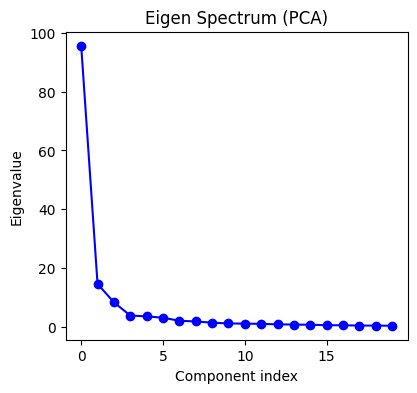

In [6]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(eigenvalues, 'bo-')
plt.title('Eigen Spectrum (PCA)')
plt.xlabel('Component index')
plt.ylabel('Eigenvalue')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

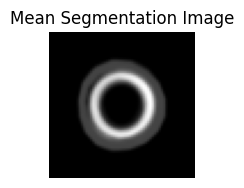

In [7]:
plt.subplot(1, 3, 2)
plt.imshow(mean_image.reshape(64, 64), cmap='gray')
plt.title('Mean Segmentation Image')
plt.axis('off')

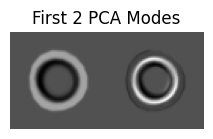

In [ ]:
plt.subplot(1, 3, 3)
mode1 = pca_model.components_[0].reshape(64, 64)
mode2 = pca_model.components_[1].reshape(64, 64)
plt.imshow(np.hstack([mode1, mode2]), cmap='gray')
plt.title('First 2 PCA Modes')
plt.axis('off')

plt.tight_layout()
plt.show()

(b)

In [ ]:
def kernel_pca(X, kernel="rbf", gamma=1e-3, n_components=20):
    K = pairwise_kernels(X, metric=kernel, gamma=gamma) 
    centerer = KernelCenterer()
    K_centered = centerer.fit_transform(K)
    eigvals, eigvecs = eigh(K_centered)
    eigvals = eigvals[::-1][:n_components]
    eigvecs = eigvecs[:, ::-1][:, :n_components]
    return eigvals, eigvecs, K_centered

In [ ]:
gamma = 1e-3  
eigvals_kpca, eigvecs_kpca, K_centered = kernel_pca(X, kernel="rbf", gamma=gamma, n_components=20)

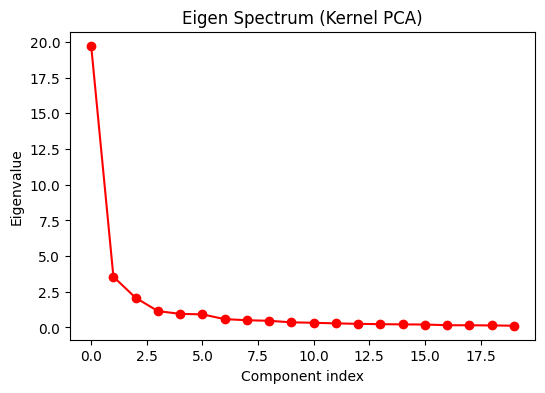

In [12]:
plt.figure(figsize=(6,4))
plt.plot(eigvals_kpca, 'ro-')
plt.title('Eigen Spectrum (Kernel PCA)')
plt.xlabel('Component index')
plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
def preimage_estimation(X, eigvecs, gamma, tol=1e-6, max_iter=100):
    preimage = np.mean(X, axis=0)
    
    for it in range(max_iter):
        k = np.exp(-np.sum((X - preimage)**2, axis=1) / (2 * (1/gamma)))
        preimage_new = np.sum(k[:, None] * X, axis=0) / np.sum(k)
        if np.linalg.norm(preimage_new - preimage) < tol:
            break
        preimage = preimage_new
    return preimage

In [14]:
preimage = preimage_estimation(X, eigvecs_kpca, gamma=gamma)

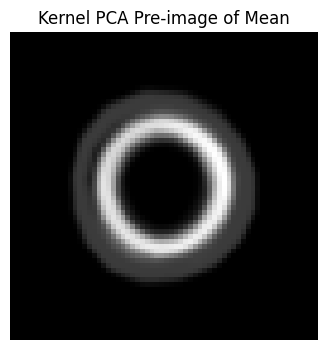

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(preimage.reshape(64,64), cmap='gray')
plt.title('Kernel PCA Pre-image of Mean')
plt.axis('off')
plt.show()

(c)

In [ ]:
def load_and_preprocess_test_images(folder, size=(64, 64)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = io.imread(os.path.join(folder, filename), as_gray=True)
            img_resized = transform.resize(img, size, anti_aliasing=True)
            img_norm = np.clip(img_resized, 0, 1)
            images.append(img_norm.flatten())
            filenames.append(filename)
    return np.array(images), filenames

In [17]:
test_folder = '/mnt/c/users/ankku/downloads/assignmentShapeAnalysis/data/anatomicalSegmentationsDistorted/distorted'
X_test, test_filenames = load_and_preprocess_test_images(test_folder)

In [ ]:
def project_and_reconstruct_pca(x, pca_model, mean_vector):
    x_centered = x - mean_vector
    components = pca_model.components_[:3]
    coeffs = components.dot(x_centered)
    x_recon = mean_vector + coeffs.dot(components)
    return x_recon

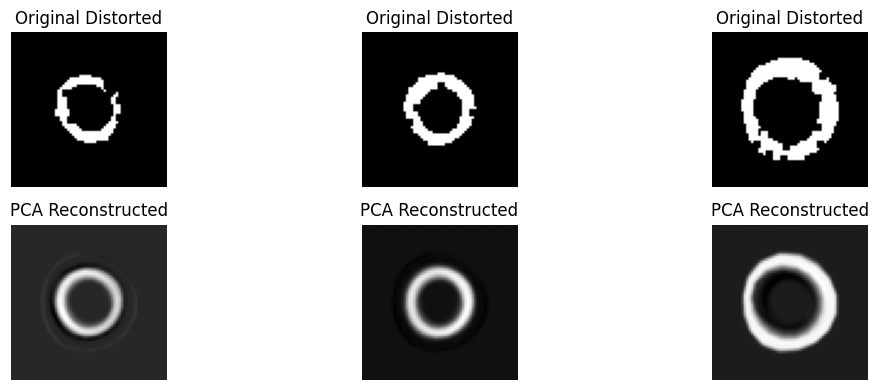

In [19]:
n_show = 3
plt.figure(figsize=(12,4))
for i in range(n_show):
    x_orig = X_test[i]
    x_recon = project_and_reconstruct_pca(x_orig, pca_model, np.mean(X, axis=0))
    plt.subplot(2, n_show, i+1)
    plt.imshow(x_orig.reshape(64,64), cmap='gray')
    plt.title('Original Distorted')
    plt.axis('off')
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(x_recon.reshape(64,64), cmap='gray')
    plt.title('PCA Reconstructed')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def compute_kernel_vector(x, X_train, kernel="rbf", gamma=1e-3):
    # x: (4096,), X_train: (M, 4096)
    diff = X_train - x
    k = np.exp(-np.sum(diff**2, axis=1) / (2/gamma))
    return k

In [ ]:
def project_and_reconstruct_kpca(x, X_train, eigvals, eigvecs, gamma=1e-3, tol=1e-6, max_iter=100):
    k = compute_kernel_vector(x, X_train, kernel="rbf", gamma=gamma)
    M = X_train.shape[0]
    one_M = np.ones(M) / M
    k_centered = k - one_M.dot(pairwise_kernels(X_train, metric="rbf", gamma=gamma)) - np.dot(pairwise_kernels(X_train, metric="rbf", gamma=gamma), one_M) + one_M.dot(pairwise_kernels(X_train, metric="rbf", gamma=gamma)).dot(one_M)
    
    coeffs = []
    for j in range(3):
        coeff = np.dot(k_centered, eigvecs[:, j])
        coeffs.append(coeff)
    coeffs = np.array(coeffs)
    

    preimage = np.mean(X_train, axis=0)
    for it in range(max_iter):
        k_pre = np.exp(-np.sum((X_train - preimage)**2, axis=1) / (2*(1/gamma)))
        preimage_new = np.sum(k_pre[:, None] * X_train, axis=0) / np.sum(k_pre)
        if np.linalg.norm(preimage_new - preimage) < tol:
            break
        preimage = preimage_new
    return preimage

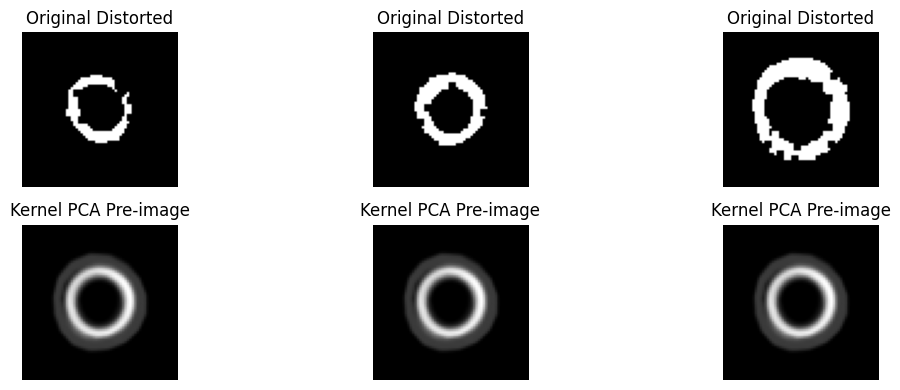

In [ ]:
plt.figure(figsize=(12,4))
for i in range(n_show):
    x_orig = X_test[i]
    preimg = project_and_reconstruct_kpca(x_orig, X, eigvals_kpca, eigvecs_kpca, gamma=gamma)
    plt.subplot(2, n_show, i+1)
    plt.imshow(x_orig.reshape(64,64), cmap='gray')
    plt.title('Original Distorted')
    plt.axis('off')
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(preimg.reshape(64,64), cmap='gray')
    plt.title('Kernel PCA Pre-image')
    plt.axis('off')
plt.tight_layout()
plt.show()